
# Prediction Market

**Collaborators: Josefina Waugh, Anne Bastian, Bridget Smart, Ebba Mark**

Preliminary model implementation of:
- Betters engage in a market trading contracts on a binary election outcome.
- Betters are endowed with initial budget, risk aversion, belief about outcome.
- Next extension will incorporate more detail into formation of this belief.

In [133]:
# Import packages
import numpy as np
import random as random
import matplotlib.pyplot as plt

### Defining Agents, Classes, Functions

In [138]:
## Defining classes
class better:
    def __init__(self): 
                # Their current budget
                self.budget = np.random.uniform(100,1000)
                # Their personal contract valuation - this will ultimately depend on their beliefs and evolve in relation to market activity
                self.market_valuation = 0.7
                # The number of contracts currently held
                self.n_contracts = 0
                # Risk aversion score (if we indeed try to vary the risk aversion)
                self.risk_av = np.random.uniform(0,1)
                # Definition (loose): your willingness to change your opinion in the face of contradicting evidence
                # Will ideally be used to process "fact" or "news" - again, loosely defined for now
                self.stubbornness = np.random.uniform(0,1)
                # TASK: consider adding inherent "expert" value here to factor into the 
                # update_belief as the noise around the true value
                # ...
                
    ### TASK
    def exp_utility(self, mkt_price, new_c):
        return self.market_valuation * self.utility(self.budget - mkt_price*new_c + self.n_contracts + new_c) + ((1-self.market_valuation)*self.utility(self.budget - mkt_price*new_c))
    
    # testing range is the range of maximum amount of contracts that can be sold at that time
    #testing_range_x = np.arange((self.budget + n_contracts, self.budget)
    #np.argmax([b.exp_utility(m, x) for x in testing_range_x])

    ## I think something like this is probably best        
    # testing_range_x = np.arange((-y-z), y) # does this range make sense? - most you can sell is -y+z, most you can buy is y
    # testing_range_x[np.argmax([exp_utility(x, rho, p, q, y, z) for x in testing_range_x])]
    
    
    def utility(self, w):
        if self.risk_av ==1:
            return np.log(w)
        else:
            return (w**(1-self.risk_av))/(1-self.risk_av)
        

    # # Function in which better sells of buys depending on their budget, market_valuation, and portfolio size
    # def buy(self, m):
    #     # Need to decide whether buyer buys the max of what is possible with their budget or not - depending on risk aversion?
    #     # For example: purchased_contracts = (1-risk_aversion)*np.round(self.budget/mkt_price)
    #     # Next step: include log function to acccommodate risk aversion
    #     # testing range is the range of maximum amount of contracts that can be sold at that time
    #     buy_range = np.arange(0, self.budget)
    #     new_contracts = np.argmax([self.exp_utility(m, x) for x in buy_range])
    #     print("Buy:", new_contracts)
    #     return new_contracts
    #     #self.n_contracts += new_contracts
    #     #self.capital -= new_contracts*mkt_price 

    def trade(self, m):
        c_range = np.arange((-1*(self.budget + self.n_contracts)), self.budget+1)
        offered_contracts = c_range[np.argmax([self.exp_utility(m, x) for x in c_range])]
        return offered_contracts
        # For example: sold_contracts = np.round((1-risk_aversion)*self.n_contracts)
        #self.n_contracts -= sold_contracts
        #self.capital += sold_contracts*mkt_price


    # Need to define a function that updates beliefs as a function of the current market price, stubbornness, (risk aversion?) and available information
    # Stubbornness for now interacts here as 1-stubbornness - could consider renaming to "openness" or "amenability" ie. antonym just for clarity.
    def update_belief(self, true_value): # stubbornness, risk aversion, information
          self.market_valuation += (1-self.stubbornness)*(np.random.normal(true_value, 0.05) - self.market_valuation)
          # ensure value is within range [0,1]
          self.market_valuation = np.clip(self.market_valuation, 0, 1)
    

-300


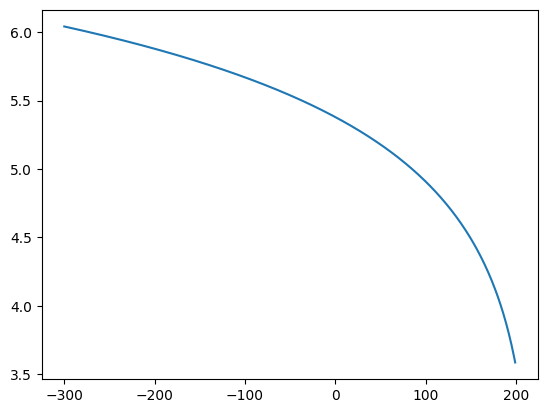

In [135]:
### TASK
rho = 1
mkt_val = 0.2
mkt = 0.9
budget = 200
n_contracts = 100

def exp_utility(mkt_val, rho, mkt, new_c, budget, contracts):
    return mkt_val * utility(rho, budget - mkt*new_c + contracts + new_c) + ((1-mkt_val)*utility(rho, budget - mkt*new_c))

def utility(rho, w):
    if rho ==1:
        return np.log(w)
    else:
        return (w**(1-self.risk_av))/(1-self.risk_av)
    
testing_range_x = np.arange((-budget-n_contracts), budget) # does this range make sense?
print(testing_range_x[np.argmax([exp_utility(mkt_val, rho, mkt, x, budget, n_contracts) for x in testing_range_x])])
plt.plot(testing_range_x, [exp_utility(mkt_val, rho, mkt, x, budget, n_contracts) for x in testing_range_x])



### Function to initialise betters


In [139]:
# Set initial parameters
parameters = {'n_betters': 500, # The number of betting agents
              'el_outcome': 1, # Ultimate election outcome - assuming we know this to begin with and it does not change over time
              't_election': 50, # Time until election takes place (ie. time horizon of betting)
              'initial_price': 0.5} # Perhaps a function of uncertainty or time until election outcome?

### Model Run

In [140]:
def run_market(n_betters, t_election, initial_price, el_outcome):
    # Initialise betting population
    betters = [better() for _ in range(n_betters)]
    orders = []
    # Initial market price
    mkt_price = initial_price

    # Record price history over time
    price_history = [mkt_price]

    # I think we need to update demand and supply after each better bets...in that case we need to random shuffle the agents
    random.shuffle(betters)
    demand = 0
    supply = 0

    for t in range(t_election):
        for b in betters:
            # With the current utility function it should be fine to just "trade" and not distinguish between buy and sell - also probably good given non-linear utility function
            b.trade(mkt_price)
            # if (b.market_valuation >= mkt_price) & (b.budget >= 1): # Each trader proposes to sell or buy conditional on market value and their utility function
            #     buy_offers = b.buy(mkt_price)
            #     demand += buy_offers
            # elif (b.market_valuation < mkt_price): #                demand += buy_offers
            #     sell_offers = b.sell(mkt_price)
            #     supply += sell_offers


        # Fulfill buy-sell orders once every better has placed their order
        #    Traders update portfolios according to fulfilled orders or not
        ...
        # Calculate supply and demand (buy contracts - sell contracts)
        ...
        #print("Demand: ", demand)
        #print("Supply:",  supply)
        # Update market price price from above difference in d and s
        ...
        price_history.append(mkt_price)
        # (Ignore for now) Traders updated their market valuation - have not yet decided how they do that...
        #      Incorporate election outcome as random walk that changes with each time step
        #      Pass this parameter to each agent with some fuzzy noise
        for b in betters:
            b.update_belief(mkt_price)
        
    return price_history

pred_market = run_market(**parameters)


946.1926131675548
Sell:  946.1926131675548
694.173772808194
Sell:  694.173772808194
180.4190755437513
Sell:  180.4190755437513
259.1479254826276
Sell:  259.1479254826276
353.10762157218096
Sell:  353.10762157218096
269.48675337857287
Sell:  269.48675337857287
408.22970626518014
Sell:  408.22970626518014
510.2584375391485
Sell:  510.2584375391485
831.1085962542455
Sell:  831.1085962542455
436.6663628311018
Sell:  436.6663628311018
769.8790253395443
Sell:  769.8790253395443
395.17997831558654
Sell:  395.17997831558654
278.0794302706143
Sell:  278.0794302706143
600.97507713242
Sell:  600.97507713242
258.11751347523676
Sell:  258.11751347523676
870.7737830739453
Sell:  870.7737830739453
464.1314800025528
Sell:  464.1314800025528
814.2172701683598
Sell:  814.2172701683598
450.82771568151225
Sell:  450.82771568151225
195.1697747628846
Sell:  195.1697747628846
267.8944362642188
Sell:  267.8944362642188
836.9497129227996
Sell:  836.9497129227996
914.9669354418319
Sell:  914.9669354418319
355.1

Questions:
- How do we update market valuation of a better (ie. what is the new information that they are processing)?
- Dynamic price updating versus once per discrete time step?




## Results

The following graph shows time series of CSE and voter intention (true intended voting behaviour of a population) in the top panel and the difference between the two estimates in the other.

In [ ]:



## Election Result
fig, ax = plt.subplots(2)
ax[0].plot(pred_market[:,0], pred_market[:,1], color = "blue", linestyle = "dotted")
ax[0].plot(el_outcome[:,0], el_outcome[:,2], color = "purple", linestyle = "dotted")
ax[1].plot(trade_vol[:,0], trade_vol[:,1], color = "red", linestyle = "dotted")
# Add title and axis labels
ax[0].set_title('Market Price')
ax[1].set_title('Trade Volume')
plt.xlabel('Time')
plt.ylabel('Result')
plt.xticks(rotation=45)
fig.tight_layout()

# Display the plot
plt.show()